Code to calculate the time when the CQD stopped emitting.

In [70]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress

In [109]:
file = 'C:/Users/HP/Downloads/TimeTags_CW_2025-01-24_102217.ttbin' #QD_51
file = 'C:/Users/HP/Downloads/TimeTags_CW_2025-01-24_120217.ttbin' #QD_52
file = 'C:/Users/HP/Downloads/TimeTags_CW_2025-01-24_131249.ttbin' #QD_53

In [110]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
fr = FileReader(file)
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-01-24 13:12:49 +0100
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [111]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

# measure photon antibunching
ch1 = config['registered channels'][0] # first photon channel for antibunching measurements
ch2 = config['registered channels'][1] # second photon channel for antibunching measurements

cr = Countrate(virtual_tagger, [ch1, ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

print(f"Rate of counts channel {ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Rate of counts channel {ch2} (counts/sec) : {cr.getData()[1]}")

Rate of counts channel 1 (counts/sec) : 13406.040960496395
Rate of counts channel 2 (counts/sec) : 12487.494551803764


In [112]:
fr = FileReader(file)
fr_copy = FileReader(file)

counts_total = 0
counts = 10000
acc_counts = np.array([])
acc_time = np.array([])

data = fr.getData(1)
t_0 = data.getTimestamps()[0]

while (fr.hasData()):
    
    data = fr.getData(counts)
    t = data.getTimestamps()
    acc_counts = np.append(acc_counts, counts_total)
    acc_time = np.append(acc_time, (np.mean(t)-t_0) / 1e12)
    counts_total += counts

In [113]:
print(len(acc_counts))
print(len(acc_time))

2793
2793


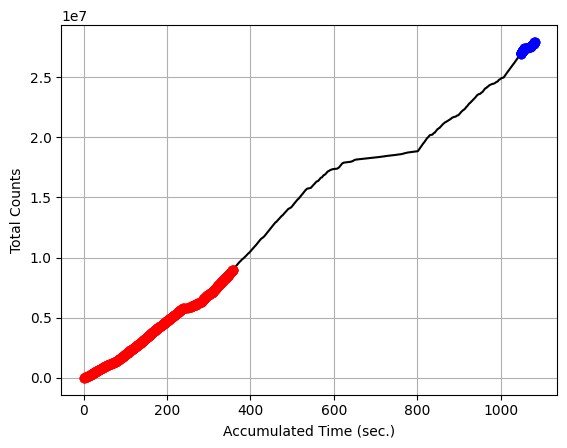

In [114]:
n_ini = 900
n_end = -100

plt.plot(acc_time, acc_counts, marker='', linestyle='-', color='k')  # Plot with line and markers
plt.plot(acc_time[:n_ini], acc_counts[:n_ini], marker='o', linestyle='-', color='r')  # Plot with line and markers
plt.plot(acc_time[n_end:], acc_counts[n_end:], marker='o', linestyle='-', color='b')  # Plot with line and markers
plt.xlabel('Accumulated Time (sec.)')  # Label for the x-axis
plt.ylabel('Total Counts')  # Label for the y-axis
plt.grid(True)  # Optional: Adds a grid
plt.show()

In [115]:
# Select the first n_ini elements
x_ini = acc_time[:n_ini]
y_ini = acc_counts[:n_ini]
# Linear fit with scipy.stats.linregress
m_ini, intercept_ini, r_value, p_value, std_err = linregress(x_ini, y_ini)
# Display results
print(f"Slope (m): {m_ini}")
print(f"Intercept (n): {intercept_ini}")

# Select the first n_ini elements
x_end = acc_time[n_end:]
y_end = acc_counts[n_end:]
# Linear fit with scipy.stats.linregress
m_end, intercept_end, r_value, p_value, std_err = linregress(x_end, y_end)
# Display results
print(f"Slope (m): {m_end}")
print(f"Intercept (n): {intercept_end}")

Slope (m): 25080.56436272117
Intercept (n): -395056.7180542378
Slope (m): 23598.78515275433
Intercept (n): 2318722.6901354194


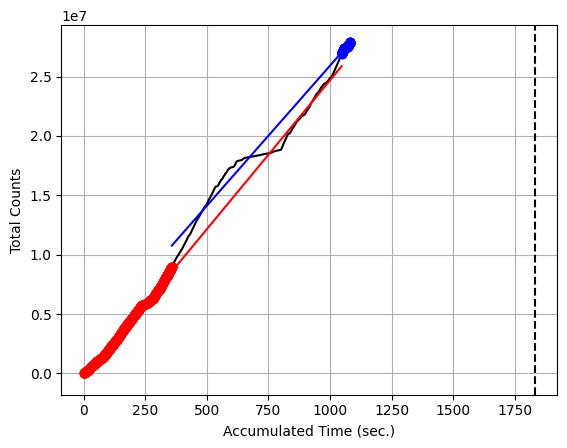

Time before beaching:  1831.4330434224362
Counts before beaching:  45538317.60351649
Counts before beaching:  45538317.60351649
Counts before beaching:  45538317.60351649


In [116]:

plt.plot(acc_time, acc_counts, marker='', linestyle='-', color='k')  # Plot with line and markers
plt.plot(acc_time[:n_ini], acc_counts[:n_ini], marker='o', linestyle='-', color='r')  # Plot with line and markers
plt.plot(acc_time[:n_end], m_ini * acc_time[:n_end] + intercept_ini, color='r', label=f'Ajuste: y={m_ini:.2f}x+{n_ini:.2f}')
plt.plot(acc_time[n_end:], acc_counts[n_end:], marker='o', linestyle='-', color='b')  # Plot with line and markers
plt.plot(acc_time[n_ini:], m_end * acc_time[n_ini:] + intercept_end, color='b', label=f'Ajuste: y={m_end:.2f}x+{n_end:.2f}')
t_bleach = (intercept_end - intercept_ini) / (m_ini - m_end)
counts_bleach = np.mean([m_ini * t_bleach + intercept_ini, m_end * t_bleach + intercept_end])
plt.axvline(x=t_bleach, color='k', linestyle='--', label=f'x = {t_bleach:.2f}')
plt.xlabel('Accumulated Time (sec.)')  # Label for the x-axis
plt.ylabel('Total Counts')  # Label for the y-axis
plt.grid(True)  # Optional: Adds a grid
plt.show()

print('Time before beaching: ', t_bleach)
print('Counts before beaching: ', counts_bleach)
print('Counts before beaching: ', m_ini * t_bleach + intercept_ini)
print('Counts before beaching: ', m_end * t_bleach + intercept_end)